In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/camvid/images'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

In [5]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/images/0001TP_008160.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0016E5_08041.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/images/0006R0_f02340.png')]

In [6]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05400_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0006R0_f02640_P.png'),
 PosixPath('/home/ubuntu/.fastai/data/camvid/labels/0016E5_05340_P.png')]

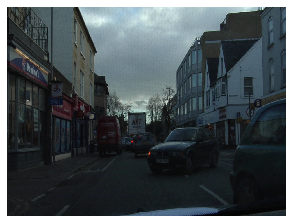

In [7]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [8]:
# What does this do?
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

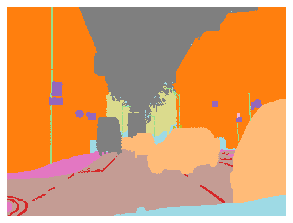

In [9]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [10]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30],
          [17, 17, 17,  ..., 30, 30, 30]]]))

In [11]:
mask.data

tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         [ 4,  4,  4,  ...,  4,  4,  4],
         ...,
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30],
         [17, 17, 17,  ..., 30, 30, 30]]])

In [12]:
src_size

array([720, 960])

In [13]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

### Datasets

In [15]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
if free > 8200:
    bs=8
else:
    bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [16]:
src = (SegmentationItemList.from_folder(path_img)
      .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [17]:
data =(src.transform(get_transforms(), size=size, tfm_y=True)
      .databunch(bs=bs)
      .normalize(imagenet_stats))

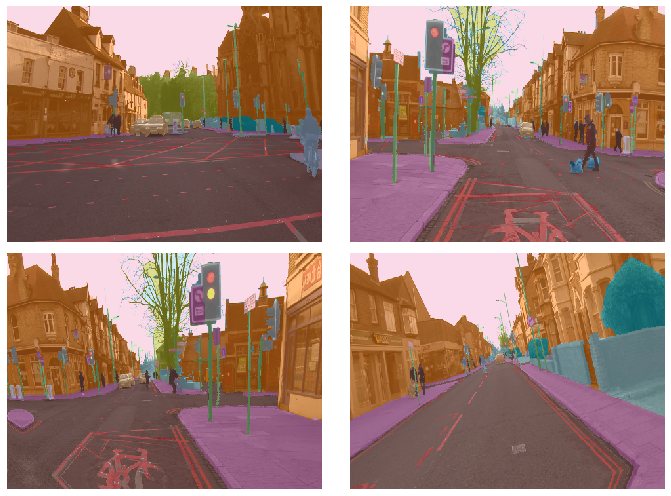

In [18]:
data.show_batch(2, figsize=(10, 7))

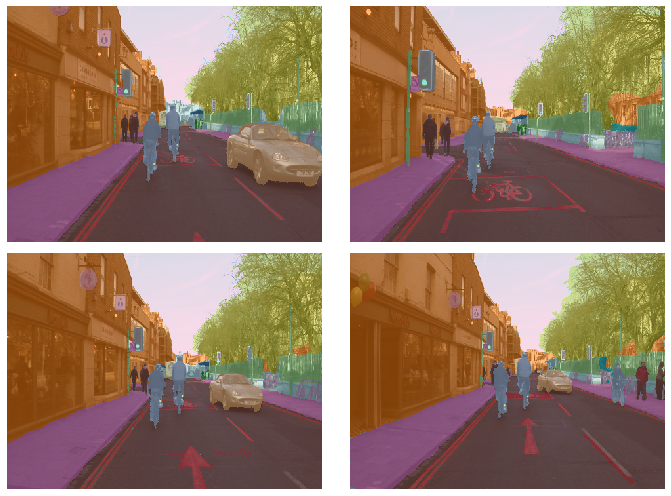

In [21]:
data.show_batch(2, figsize=(10, 7), ds_type=DatasetType.Valid)

### Model

In [22]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [23]:
metrics = acc_camvid

In [24]:
wd = 1e-2

In [25]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [26]:
type(learn)

fastai.basic_train.Learner

epoch     train_loss  valid_loss  acc_camvid  time    
0         13.242011   #na#        03:28       
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


/home/ubuntu/anaconda3/lib/python3.7/site-packages/fastai/sixel.py:16: UserWarning: You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel
  warn("You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel")


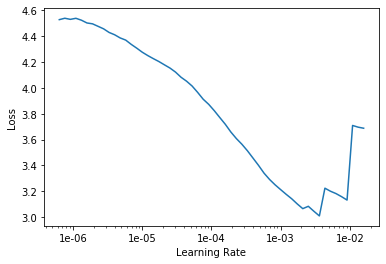

In [27]:
lr_find(learn)
learn.recorder.plot()

In [28]:
lr = 3e-3

In [29]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch     train_loss  valid_loss  acc_camvid  time    
0         1.274801    0.864301    0.769754    03:28     
1         0.869028    0.655590    0.837837    03:28     
2         0.687747    0.568256    0.843242    03:27     
3         0.652717    0.563674    0.863804    03:27     
4         0.590960    0.524140    0.867366    03:26     
5         0.622378    0.562112    0.857608    03:25     
6         0.606726    0.444292    0.878660    03:24     
7         0.565657    0.451252    0.866986    03:24     
8         0.537988    0.466048    0.883524    03:23     
9         0.472102    0.362108    0.897640    03:23     


In [30]:
learn.save('stage-1')

In [31]:
learn.load('stage-1');

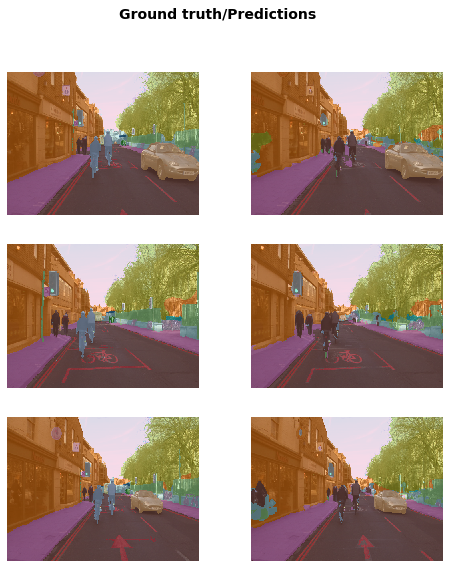

In [32]:
learn.show_results(rows=3, figsize=(8,9))

In [33]:
learn.unfreeze()

In [34]:
lrs = slice(lr/400, lr/4)

In [35]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch     train_loss  valid_loss  acc_camvid  time    
0         0.405468    0.345847    0.900262    03:30     
1         0.394789    0.330098    0.906227    03:30     
2         0.379772    0.321319    0.909063    03:30     
3         0.376275    0.328375    0.903405    03:31     
4         0.366158    0.314035    0.910498    03:31     
5         0.361359    0.334024    0.906432    03:31     
6         0.349274    0.348126    0.903683    03:30     
7         0.345884    0.312690    0.909844    03:31     
8         0.341098    0.301130    0.916487    03:31     
9         0.322222    0.281315    0.921891    03:31     
10        0.297799    0.294857    0.914945    03:31     
11        0.268300    0.291824    0.917417    03:31     


In [36]:
learn.save('stage-2');

### Go Big